In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#훈련

In [ ]:
# tokenizer 저장 및 로딩을 위한 초기화 코드
from transformers import AutoTokenizer

# ELECTRA-small 모델로 변경
checkpoint = "beomi/KcELECTRA-small-v2022"
shared_tokenizer_path = "/content/drive/MyDrive/Capstone/shared_tokenizer"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.save_pretrained(shared_tokenizer_path)
print(f"Tokenizer saved to {shared_tokenizer_path}")

Tokenizer saved to /content/drive/MyDrive/Capstone/shared_tokenizer


In [ ]:
# 공통 라이브러리
import json
import numpy as np
import random
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

# task 설정: "binary" 또는 "multi"
task = "multi"
print(task)
# 공통 tokenizer 경로
shared_tokenizer_path = "/content/drive/MyDrive/Capstone/shared_tokenizer"
tokenizer = AutoTokenizer.from_pretrained(shared_tokenizer_path)

multi


In [ ]:
import json
from zipfile import ZipFile
import random


# JSON 데이터 로드 함수
def load_json_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

if task == "binary":
    # Placeholder for binary task - modify as needed
    train_data = load_json_dataset("your_binary_train_file.json")
    for item in train_data:
        item["labels"] = item["binary_label"]
else:
    train_data = load_json_dataset("/content/drive/MyDrive/Capstone/multiData/multi_train.json")
    for item in train_data:
        item["labels"] = item["category_labels"]

# ✅ 공통: 무작위 셔플 및 validation set 추출
random.shuffle(train_data)
split_idx = int(len(train_data) * 0.2)
val_data = train_data[:split_idx]
train_data = train_data[split_idx:]

# Define the path to save the validation data in Google Drive
save_path = "/content/drive/MyDrive/Capstone/multiData/multi_val.json"

# Save the validation data to the specified path
with open(save_path, 'w', encoding='utf-8') as f:
    json.dump(val_data, f, ensure_ascii=False, indent=4)



In [ ]:
# DatasetDict 생성 및 토크나이징
dataset = DatasetDict({
    'train': Dataset.from_list(train_data),
    'validation': Dataset.from_list(val_data),
})

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/82227 [00:00<?, ? examples/s]

Map:   0%|          | 0/20556 [00:00<?, ? examples/s]

In [ ]:
# 다중 분류용 라벨 매핑 처리
if task == "multi":
    label2id = {
        '디자인/외형': 0,
        '성능/기능': 1,
        '편의성/사용감': 2,
        '가격/구성': 3,
        '품질/내구성': 4,
    }
    id2label = {v: k for k, v in label2id.items()}

    def valid_category(example):
        return "category_labels" in example

    def map_category_label(example):
        example["labels"] = label2id.get(example["category_labels"], -1)
        return example

    filtered_train = tokenized_dataset["train"].filter(valid_category).map(map_category_label)
    filtered_val = tokenized_dataset["validation"].filter(valid_category).map(map_category_label)
    filtered_train = filtered_train.filter(lambda x: x["labels"] != -1)
    filtered_val = filtered_val.filter(lambda x: x["labels"] != -1)

    train_set = filtered_train
    val_set = filtered_val
else:
    train_set = tokenized_dataset["train"]
    val_set = tokenized_dataset["validation"]

Filter:   0%|          | 0/82227 [00:00<?, ? examples/s]

Map:   0%|          | 0/82227 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20556 [00:00<?, ? examples/s]

Map:   0%|          | 0/20556 [00:00<?, ? examples/s]

Filter:   0%|          | 0/82227 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20556 [00:00<?, ? examples/s]

In [ ]:
# 모델 및 metric 설정
if task == "binary":
    model = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-small-v2022", num_labels=2)
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds)
        }
    output_dir = "/content/drive/MyDrive/Capstone/binary_model"
else:
    model = AutoModelForSequenceClassification.from_pretrained(
        "beomi/KcELECTRA-small-v2022",
        num_labels=5,
        id2label=id2label,
        label2id=label2id
    )
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1_macro": f1_score(labels, preds, average="macro")
        }
    output_dir = "/content/drive/MyDrive/Capstone/multi_model"

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-small-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Trainer 정의 및 학습
args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-54-852dd97bf5d9>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.502500,0.364184,0.877165,0.874128
2,0.336300,0.336699,0.889035,0.886006


TrainOutput(global_step=10280, training_loss=0.41937760527495743, metrics={'train_runtime': 722.147, 'train_samples_per_second': 227.729, 'train_steps_per_second': 14.235, 'total_flos': 1209641781164544.0, 'train_loss': 0.41937760527495743, 'epoch': 2.0})

In [ ]:
trainer.save_model(output_dir)

print("\n=== Validation Loss per Epoch ===")
for log in trainer.state.log_history:
    if "eval_loss" in log:
        print(f"Epoch {log['epoch']:.2f} - eval_loss: {log['eval_loss']:.4f}")

NameError: name 'trainer' is not defined

#추론

comprehend

In [ ]:
!pip install boto3
import os

# 키를 환경 변수에 저장 (임시 세션에만 유지됨)
os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''
os.environ['AWS_REGION'] = 'ap-northeast-2'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 7.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import boto3
import json

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ tokenizer 로딩
tokenizer_path = "/content/drive/MyDrive/Capstone/shared_tokenizer"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# ✅ 모델 로딩
binary_model_path = "/content/drive/MyDrive/Capstone/binary_model"
multi_model_path = "/content/drive/MyDrive/Capstone/multi_model"

binary_model = AutoModelForSequenceClassification.from_pretrained(binary_model_path)
multi_model = AutoModelForSequenceClassification.from_pretrained(multi_model_path)

binary_model.to(device)
multi_model.to(device)
binary_model.eval()
multi_model.eval()

# ✅ multi classification label mapping
id2label = {
    0: '디자인/외형',
    1: '성능/기능',
    2: '편의성/사용감',
    3: '가격/구성',
    4: '품질/내구성',
}

# ✅ AWS Comprehend 클라이언트
comprehend = boto3.client('comprehend', region_name='ap-northeast-2')


# ✅ 추론 파이프라인
def predict_pipeline(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 1️⃣ Binary
    with torch.no_grad():
        binary_outputs = binary_model(**inputs)
        binary_probs = F.softmax(binary_outputs.logits, dim=1)
        binary_pred = torch.argmax(binary_probs, dim=1).item()

    if binary_pred == 0:
        return {
            "binary_label": 0,
            "multi_classification": None,
            "sentiment": None
        }

    # 2️⃣ Multi
    with torch.no_grad():
        multi_outputs = multi_model(**inputs)
        multi_probs = F.softmax(multi_outputs.logits, dim=1)
        multi_pred = torch.argmax(multi_probs, dim=1).item()

    # 3️⃣ AWS Sentiment
    sentiment_result = comprehend.detect_sentiment(
        Text=text,
        LanguageCode='ko'  # 한국어
    )

    return {
        "binary_label": 1,
        "multi_classification": {
            "category_labels": id2label[multi_pred],
            "confidence": round(multi_probs[0][multi_pred].item(), 4)
        },
        "sentiment": {
            "label": sentiment_result['Sentiment'],
            "scores": sentiment_result['SentimentScore']
        }
    }


In [ ]:
from collections import defaultdict

with open("test.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# 결과를 카테고리별로 저장할 딕셔너리
results_by_category = defaultdict(list)

for item in test_data:
    text = item["text"]
    prediction = predict_pipeline(text)

    if prediction["binary_label"] == 1:
        sentiment_scores = prediction["sentiment"]["scores"]
        top_sentiment = max(sentiment_scores, key=sentiment_scores.get)

        category = prediction["multi_classification"]["category_labels"]
        confidence = prediction["multi_classification"]["confidence"]

        result = {
            "text": text,
            "confidence": confidence,
            "sentiment": top_sentiment,
            "score": round(sentiment_scores[top_sentiment], 4)
        }

        results_by_category[category].append(result)

# 카테고리별로 confidence 내림차순 정렬 후 출력
for category, items in results_by_category.items():
    print(f"\n📂 Category: {category}")
    sorted_items = sorted(items, key=lambda x: x["confidence"], reverse=True)
    for entry in sorted_items:
        print(entry)



📂 Category: 편의성/사용감
{'text': '너무나도 유용해요😮', 'confidence': 0.9945, 'sentiment': 'Positive', 'score': 0.9993}
{'text': '직구한 갤럭시 기기는 가입이 불가한 점이 안쉽더라고요.', 'confidence': 0.9525, 'sentiment': 'Negative', 'score': 0.9826}
{'text': '안누를 수 없는 인트로 ㅋㅋㅋㅋㅋㅋㅋㅋ', 'confidence': 0.9521, 'sentiment': 'Neutral', 'score': 0.5075}
{'text': '음.. 1순위가 무게와.휴대성. 그립감이라 <br>일반형이 땡기긴 하는데<br>그놈에 60hz..', 'confidence': 0.6399, 'sentiment': 'Neutral', 'score': 0.8903}
{'text': '전면 카메라 비교는 의미가 없나요?', 'confidence': 0.5549, 'sentiment': 'Neutral', 'score': 0.5924}
{'text': 'aod 따로 끌수도 있나요?', 'confidence': 0.5371, 'sentiment': 'Neutral', 'score': 0.9878}

📂 Category: 가격/구성
{'text': '제가 요즘 고민하는 문제가 15프로맥스와 16프로를 놓고 뭘 사야할지를 모르겠습니다. 15프로맥스가 요즘 할인이 많이 들어가서 16프로보다 저렴해졌더군요. 단순히 화면의 크기 차이를 제외한다면 16프로 최신 성능을 사는게 나을까요? 아니면 가격도 낮아졌겠다 15프로맥스를 사는게 나을까요?', 'confidence': 0.9861, 'sentiment': 'Negative', 'score': 0.8827}
{'text': '결국 바뀐거 없는거 같아서 12미니에서 15프로맥스로 샀습니다 ㅎㅎ 굳이 정가주고 16프맥사느니 할인받고 15프맥 사는게 이득같더라고요. 색도 15프맥이 이쁜거같고요', 'confidenc

# 이진모델 테스트

In [ ]:
def predict_binary_only(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        binary_outputs = binary_model(**inputs)
        binary_probs = F.softmax(binary_outputs.logits, dim=1)
        binary_pred = torch.argmax(binary_probs, dim=1).item()

    return binary_pred


✅ Accuracy: 0.7737
✅ F1 Score: 0.6504


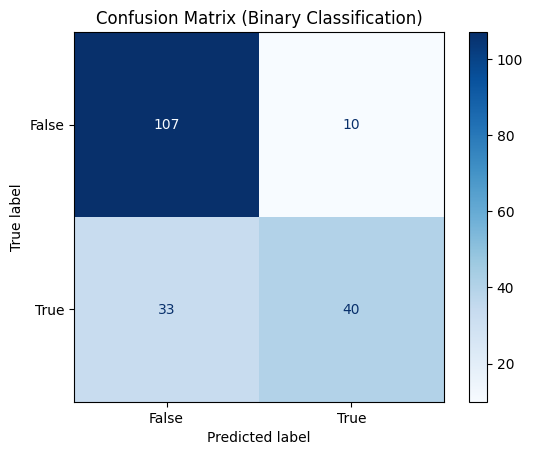

In [ ]:
import json
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ 테스트셋 로드
with open("test.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# ✅ 예측 수행
y_true = []
y_pred = []

for item in test_data:
    text = item["text"]
    true_label = item["binary_label"]  # 실제 이진 라벨
    pred_label = predict_binary_only(text)

    y_true.append(true_label)
    y_pred.append(pred_label)

# ✅ 성능 출력
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# ✅ Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Binary Classification)")
plt.show()
